In [1]:
import numpy as np
import os
from  PIL import Image
import matplotlib.pyplot as plt
import cv2
import json

In [171]:
def load_images_from_folder(folder, target_size=(48, 32)):
    # pomocnicza funkcja do załadowania do zmiennej zdjęć z dysku
    # zdjęcia są normalizowane i konwertowane do fat32
    images = []
    for filename in sorted(os.listdir(folder)): 
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            with Image.open(img_path) as img:
                img = img.resize(target_size)
                img = np.array(img) 
                img = img.astype('float16') / 255.0
                images.append(img)
    return np.array(images)

In [172]:
def load_segments_from_folder(folder, target_size=(48, 32), num_classes=12):
    # pomocnicza funkcja do odczyty posegmentowanych masek
    # w pierwotnym założeniu zdjęcia posegmentowane są maskami posiadającymi etykiety w kanale czerwonym
    # wartość piksela odpowiada danej klasie
    
    images = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            with Image.open(img_path) as img:
                img = img.resize(target_size, Image.NEAREST) 
                img = np.array(img, dtype='uint8')

                if img.ndim > 2:
                    img = img[..., 0]

                img_one_hot = np.zeros((*target_size[::-1], num_classes), dtype='float16') 

                # encoding one hot
                for c in range(num_classes):
                    img_one_hot[..., c] = (img == c).astype('float16')

                images.append(img_one_hot)
    return np.array(images)

In [4]:
def combine_masks(masks):
    if masks.ndim == 4:  # paczka obrazów
        n_images, height, width, n_channels = masks.shape
        combined_masks = np.zeros((n_images, height, width), dtype=np.uint8)
        for i in range(n_images):
            for channel in range(n_channels):
                combined_masks[i][masks[i, :, :, channel] == 1] = channel + 1
    elif masks.ndim == 3:  # pojedynczy obraz
        height, width, n_channels = masks.shape
        combined_masks = np.zeros((height, width), dtype=np.uint8)
        for channel in range(n_channels):
            combined_masks[masks[:, :, channel] == 1] = channel + 1
    else:
        raise ValueError("Niewłaściwe wymiary wejściowe. Oczekiwano 3 lub 4 wymiarów.")

    return combined_masks

In [5]:
def display_images(original_images, processed_images, image_index=0, channel_index=0):
    # Złożenie kanałów dla obu obrazów
    combined_original = combine_masks(original_images[image_index])
    combined_processed = combine_masks(processed_images[image_index])

    # Wybór pojedynczych kanałów dla obu obrazów
    single_original = original_images[image_index, :, :, channel_index]
    single_processed = processed_images[image_index, :, :, channel_index]

    # Ustawienie subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Dostosuj rozmiar według potrzeb

    # Wyświetlenie złożonego pierwszego obrazu
    axs[0].imshow(combined_original)
    axs[0].set_title('Złożony obraz oryginalny')
    axs[0].axis('off')  # Wyłączenie osi

    # Wyświetlenie wybranego kanału z pierwszego obrazu
    axs[1].imshow(single_original)
    axs[1].set_title(f'Kanał {channel_index} oryginalnego')
    axs[1].axis('off')

    # Wyświetlenie wybranego kanału z drugiego obrazu
    axs[2].imshow(single_processed)
    axs[2].set_title(f'Kanał {channel_index} obrazu przetworzonego')
    axs[2].axis('off')

    # Wyświetlenie złożonego drugiego obrazu
    axs[3].imshow(combined_processed)
    axs[3].set_title('Złożony obraz przetworzony')
    axs[3].axis('off')

    plt.show()

In [6]:
def visualize_weights(weights, num_columns=6):
    # funkcja pomocnicza do graficznej reprezentacji wag danej warstwy
    #do wywołania z np layer.kernel

    num_kernels = weights.shape[3]
    
    # oblicza liczbę wierszy potrzebnych do wyświetlenia wag
    num_rows = num_kernels // num_columns + (num_kernels % num_columns > 0)
    
    # siatka wykresów
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns, num_rows))
    
    # normalizacja wag
    min_w = np.min(weights)
    max_w = np.max(weights)
    weights = (weights - min_w) / (max_w - min_w)

    for i, ax in enumerate(axes.flat):
        if i < num_kernels:
            filter = weights[:, :, :, i]
            # jeśli kernel ma więcej niż jeden kanał, wuświetli się w kolorze
            if filter.shape[2] == 3:
                ax.imshow(filter)
            else:
                # jeśli to kernel jednowymiarowy, użyj mapy kolorów
                ax.imshow(filter.squeeze(), cmap='gray')
        
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # ukryj puste subplots
            ax.axis('off')
    plt.show()

In [7]:
def calculate_gradient_norm(gradient):
    return np.linalg.norm(gradient)

In [8]:
class SGDOptimizer:
    def __init__(self, learning_rate=0.01, momentum=0.0, weight_decay=0.0):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = {}
        self.weight_decay = weight_decay  # współczynnik regularyzacji L2

    def update(self, layer_id, params, grads):
        if layer_id not in self.velocity:
            self.velocity[layer_id] = np.zeros_like(params)
        # zaktualizuj prędkość z uwzględnieniem momentum
        self.velocity[layer_id] = self.momentum * self.velocity[layer_id] - self.learning_rate * grads
        # dodaj regularyzację L2 do prędkości
        self.velocity[layer_id] -= self.learning_rate * self.weight_decay * params
        # zaktualizuj parametry
        params += self.velocity[layer_id]

In [9]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # pierwszy moment (średnia ruchoma gradientu)
        self.v = {}  # drugi moment (średnia ruchoma kwadratu gradientu)
        self.t = 0   # licznik iteracji

    def update(self, layer_id, params, grads):
        # inicjalizacja m i v, jeśli nie istnieją dla danego id warstwy
        if layer_id not in self.m:
            self.m[layer_id] = np.zeros_like(params)
            self.v[layer_id] = np.zeros_like(params)

        # inkrementacja licznika iteracji
        self.t += 1

        # aktualizacja m i v
        self.m[layer_id] = self.beta1 * self.m[layer_id] + (1 - self.beta1) * grads
        self.v[layer_id] = self.beta2 * self.v[layer_id] + (1 - self.beta2) * (grads ** 2)

        # korekcja odchylenia dla m i v
        m_corrected = self.m[layer_id] / (1 - self.beta1 ** self.t)
        v_corrected = self.v[layer_id] / (1 - self.beta2 ** self.t)

        # aktualizacja parametrów
        params -= self.learning_rate * m_corrected / (np.sqrt(v_corrected) + self.epsilon)


In [10]:
class LossFunction:
    @staticmethod
    def binary_cross_entropy(predicted, true):
        # mały epsilon dla dzielenia przez 0
        epsilon = 1e-15

        # ograniczenie przewidywanych wartości do zakresu [epsilon, 1 - epsilon] aby zapobiec błędom numerycznym podczas logarytmowania
        predicted = np.clip(predicted, epsilon, 1 - epsilon)

        # Obliczanie entropii krzyżowej między prawdziwymi a przewidywanymi etykietami dla klasyfikacji binarnej
        return -np.mean(true * np.log(predicted) + (1 - true) * np.log(1 - predicted))

In [11]:
class StableSigmoid:
    def forward(self, x):
        positive_mask = (x >= 0)
        negative_mask = (x < 0)
        z = np.zeros_like(x)
        z[positive_mask] = 1 / (1 + np.exp(-x[positive_mask]))
        z[negative_mask] = np.exp(x[negative_mask]) / (1 + np.exp(x[negative_mask]))
    
        self.output = z
        return z
    def backward(self, dout):
        dz = self.output * (1 - self.output) * dout
        return dz

In [12]:
class StableSoftmax:
    def forward(self, x):
        # odjęcie maksymalnej wartość w każdym kanale dla stabilności numerycznej
        shift_x = x - np.max(x, axis=-1, keepdims=True)
        exps = np.exp(shift_x)
        self.output = exps / np.sum(exps, axis=-1, keepdims=True)
        return self.output

    def backward(self, dout):
        dx = np.zeros_like(dout)

        # uproszczona metoda bez obliczania macierzy jacobiego- ograniczone zasoby obliczeniowe
        for i in range(dout.shape[0]):
            for h in range(dout.shape[1]):
                for w in range(dout.shape[2]):
                    softmax_output = self.output[i, h, w]
                    sum_dout_softmax = np.sum(dout[i, h, w] * softmax_output)
                    dx[i, h, w] = softmax_output * (dout[i, h, w] - sum_dout_softmax)
        
        return dx

In [13]:
class ReLULayer:
    def forward(self, input):
        self.input = input 
        return np.maximum(0, input)

    def backward(self, dout):
        dinput = dout.copy()
        dinput[self.input <= 0] = 0
        return dinput

In [14]:
class LeakyReLULayer:
    def __init__(self, alpha=0.01):
        # alpha- małe współczynniki do "przeciekania" ujemnych gradientów
        self.alpha = alpha 

    def forward(self, input):
        # LeakyReLU = max(x, mała stała * x),
        self.input = input
        return np.where(input > 0, input, self.alpha * input)

    def backward(self, output_gradient):
        if self.input.shape != output_gradient.shape:
            raise ValueError(f"Niepoprawny kształt gradientu wyjściowego dla LeakyReLU: oczekiwano {self.input.shape}, otrzymano {output_gradient.shape}")
        # gradient to 1 dla x > 0 i alpha dla x <= 0
        input_gradient = np.where(self.input > 0, 1, self.alpha)
        return output_gradient * input_gradient

In [15]:
class PoolingLayer:
    def __init__(self, pool_size=2):
        self.pool_size = pool_size
        self.input = None
        self.max_indices = None

    def forward(self, input):
        # dane wejściowe są zapisywane, następnie przeprowadzany jest forward pass
        self.input = input
        B, H, W, C = input.shape 

        # tablica dla indeksów maksymalnych wartości i wyniku poolingu, jest wykorzystywana do bacward pass
        self.max_indices = np.zeros((B, H // self.pool_size, W // self.pool_size, C), dtype=int)
        output = np.zeros((B, H // self.pool_size, W // self.pool_size, C))

        # iteracja po liczbie danych, kernelach, wyokości i szerokości mapy
        for batch in range(B):
            for kernel in range(C):
                for height in range(0, H, self.pool_size):
                    for width in range(0, W, self.pool_size):
                        # wycięcie fragmentu danych wejściowych
                        slice = input[batch, height:height+self.pool_size, width:width+self.pool_size, kernel]
                        # zapisanie indeksu maksymalnej wartości w wycinku
                        self.max_indices[batch, height // self.pool_size, width // self.pool_size, kernel] = np.argmax(slice)
                        # zapis maksymalnej wartości
                        output[batch, height // self.pool_size, width // self.pool_size, kernel] = np.max(slice)

        return output

    def backward(self, dout):
        B, H, W, C = self.input.shape
        dinput = np.zeros_like(self.input)

        for batch in range(B):
            for depth in range(C):
                for height in range(dout.shape[1]):
                    for width in range(dout.shape[2]):
                        # wyznaczenie indeksów w oryginalnym obrazie
                        index = self.max_indices[batch, height, width, depth]
                        h_idx = height * self.pool_size + index // self.pool_size
                        w_idx = width * self.pool_size + index % self.pool_size
                        # przypisanie gradientu do odpowiedniego miejsca
                        dinput[batch, h_idx, w_idx, depth] = dout[batch, height, width, depth]

        return dinput

In [16]:
class UpSamplingLayer:
    def __init__(self, scale=2):
        self.scale = scale

    def forward(self, input):
        self.input = input 
        return np.repeat(np.repeat(input, self.scale, axis=1), self.scale, axis=2)

    # def backward(self, dout):
    #     B, H, W, C = self.input.shape
    #     dout_downsampled = dout[:, ::self.scale, ::self.scale, :]
    #     return dout_downsampled
    def backward(self, dout):
        B, H, W, C = self.input.shape
        dout_upsampled = np.zeros_like(self.input)
        
        for b in range(B):
            for h in range(H):
                for w in range(W):
                    for c in range(C):
                        i = h * self.scale
                        j = w * self.scale
                        # Gradient jest rozdzielany równomiernie pomiędzy wszystkie elementy, które zostały zduplikowane w forward
                        dout_upsampled[b, h, w, c] = np.sum(dout[b, i:i+self.scale, j:j+self.scale, c]) / (self.scale**2)
        
        return dout_upsampled

In [18]:
class BatchNormLayer:
    #[Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html.
    #[Online]. Available: https://github.com/renan-cunha/BatchNormalization.
    def __init__(self, num_features, name=None):
        self.gamma = np.ones((1, num_features))
        self.beta = np.zeros((1, num_features))
        self.moving_mean = np.zeros((1, num_features))
        self.moving_variance = np.ones((1, num_features))  # inicjalizacja na 1 zapobiega dzieleniu przez 0

        self.name = name
        self.epsilon = 1e-3
        self.training = False

    def forward(self, X, momentum=0.9):
        B, H, W, C = X.shape
        self.input_reshaped = X.reshape(-1, C)

        if self.training:
            self.batch_mean = np.mean(self.input_reshaped, axis=0, keepdims=True)
            self.batch_variance = np.var(self.input_reshaped, axis=0, keepdims=True)

            self.moving_mean = momentum * self.moving_mean + (1 - momentum) * self.batch_mean
            self.moving_variance = momentum * self.moving_variance + (1 - momentum) * self.batch_variance

            self.X_normalized = (self.input_reshaped - self.batch_mean) / np.sqrt(self.batch_variance + self.epsilon)
        else:
            self.X_normalized = (self.input_reshaped - self.moving_mean) / np.sqrt(self.moving_variance + self.epsilon)

        self.output_reshaped = self.gamma * self.X_normalized + self.beta
        return self.output_reshaped.reshape(B, H, W, C)

    def backward(self, grad_output):
        B, H, W, C = grad_output.shape
        grad_output_reshaped = grad_output.reshape(-1, C)

        self.dbeta = np.sum(grad_output_reshaped, axis=0)
        self.dgamma = np.sum(self.X_normalized * grad_output_reshaped, axis=0)

        dX_normalized = grad_output_reshaped * self.gamma
        dX_mu1 = dX_normalized * 1 / np.sqrt(self.batch_variance + self.epsilon)
        dX_mu2 = np.sum(dX_normalized * -1 / np.sqrt(self.batch_variance + self.epsilon), axis=0)
        dvar = np.sum(dX_normalized * -0.5 * (self.input_reshaped - self.batch_mean) / (self.batch_variance + self.epsilon)**(3/2), axis=0)

        dX = (dX_mu1 + (2 / B) * (self.input_reshaped - self.batch_mean) * dvar + dX_mu2 / B).reshape(B, H, W, C)
        
        return dX

    def update_params(self, learning_rate):
        self.gamma -= learning_rate * self.dgamma
        self.beta -= learning_rate * self.dbeta


In [19]:
class ConvLayer:
    def __init__(self, num_kernels, kernel_size, kernel_depth, stride=1, padding=0, name=None):
        # init obiektu warstwy konwolucyjnej
        # parametry : liczba kerneli, rozmiar kerneli (kwadratowy size x size), głębokość kerneli, stride i padding z wartościami domyślnymi
        # dkernels przechowuje gradienty dla kerneli
        # inicjalizacja wag 
        
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.kernel_depth = kernel_depth
        self.stride = stride
        self.padding = padding
        self.name = name
        # inicjalizacja wag z rozkładu normalnego
        #self.kernels = np.random.standard_normal((num_kernels, kernel_size, kernel_size, kernel_depth))
        # inicjalizacja He
        limit = np.sqrt(6 / (kernel_depth + num_kernels))
        self.kernels = np.random.uniform(-limit, limit, (num_kernels, kernel_size, kernel_size, kernel_depth))
        # [Online]. Available: https://medium.com/@shauryagoel/kaiming-he-initialization-a8d9ed0b5899
        # [Online]. Available: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks.

        self.dkernels = np.zeros_like(self.kernels)

    def forward(self, input):
        # metoda w przód warstwy konwolucyjnej
        # pobiera obraz jako argument, zwraca przetworozny obraz
        # pozostałe dane są właściwością obiektu
        
        self.input = input 
        stride = self.stride
        padding = self.padding

        # padding mapy wejściowej
        input_padded = np.pad(input, [(0, 0), 
                                      (padding, padding),
                                      (padding, padding), 
                                      (0, 0)], 
                                    mode='edge')

        # rozmiar mapy wejściowej
        batch_size, input_height, input_width, input_channels = input_padded.shape

        # obsługa błędu liczby kanałów
        if input_channels != self.kernels.shape[3]:
            raise ValueError("The number of input channels must match the number of kernel channels.")

        # rozmiar mapy wyjściowej
        output_height = ((input_height - self.kernel_size) // stride) + 1
        output_width = ((input_width - self.kernel_size) // stride) + 1

        # init mapy wyjściowej
        output = np.zeros((batch_size, output_height, output_width, self.num_kernels))


        # # wersja oryginalna
        # #___________________________________________________________________________________________________________________________________
        # # pętla po przykąłdach w batchu
        # for batch in range(batch_size):
        #     # pętla po kernelach
        #     for kernel in range(self.num_kernels):
        #         # pętla pionowa
        #         for height in range(0, output_height):
        #             # pętla pozioma
        #             for width in range(0, output_width):
        #                 # określenie rogów wycinka
        #                 vertical_start = height * stride
        #                 vertical_end = vertical_start + self.kernel_size
        #                 horizontal_start = width * stride
        #                 horizontal_end = horizontal_start + self.kernel_size

        #                 # wycięzcie fragmentu macierzy
        #                 current_slice = input_padded[batch, vertical_start:vertical_end, horizontal_start:horizontal_end, :]
        #                 # operacja konwolucji
        #                 output[batch, height, width, kernel] = np.sum(current_slice * self.kernels[kernel, :, :, :])
        # #___________________________________________________________________________________________________________________________________

        # # Wersja 2, szybsza
        #___________________________________________________________________________________________________________________________________
        # reshape kerneli
        kernels_reshaped = self.kernels.reshape(self.num_kernels, -1).T
        # pętle po wysokości i szerokości mapy
        for i in range(output_height):
            for j in range(output_width):
                # wycinanie fragmentów macierzy
                slice = input_padded[:, i*stride:i*stride+self.kernel_size, j*stride:j*stride+self.kernel_size, :]
                slice_reshaped = slice.reshape(batch_size, -1)

                # konwolucja wektorowa
                output[:, i, j, :] = np.dot(slice_reshaped, kernels_reshaped).reshape(-1, self.num_kernels)
        #___________________________________________________________________________________________________________________________________

        return output

    def backward(self, dout):
        # dinput gradient względem wejścia - pochodna błędu względem wejścia
        # dout gradient względem wyjścia - pochodna błędu względem wyjścia
        
        stride = self.stride
        padding = self.padding
        batch_size, dout_height, dout_width, num_kernels = dout.shape
        dinput = np.zeros_like(self.input)
        padded_input = np.pad(self.input, 
                            [(0, 0), 
                            (padding, padding), 
                            (padding, padding), 
                            (0, 0)], 
                            mode='edge')
        padded_dinput = np.pad(dinput, 
                            [(0, 0), 
                            (padding, padding), 
                            (padding, padding), 
                            (0, 0)], 
                            mode='edge')
        
        # obliczenie gradientu dla wag
        for kernel in range(num_kernels):
            for batch in range(batch_size):
                for height in range(dout_height):
                    for width in range(dout_width):
                        vertical_start = height * stride
                        vertical_end = vertical_start + self.kernel_size
                        horizontal_start = width * stride
                        horizontal_end = horizontal_start + self.kernel_size
                        padded_input_slice = padded_input[batch, vertical_start:vertical_end, horizontal_start:horizontal_end, :]
                        # wkład w gradient
                        self.dkernels[kernel] += dout[batch, height, width, kernel] * padded_input_slice

        # normalizacja gradientów przez rozmiar batcha
        self.dkernels /= batch_size

        # obliczenie gradientu dla wejść
        for batch in range(batch_size):
            for height in range(dout_height):
                for width in range(dout_width):
                    vertical_start = height * stride
                    vertical_end = vertical_start + self.kernel_size
                    horizontal_start = width * stride
                    hori_end = horizontal_start + self.kernel_size

                    # dla wszystkich kerneli
                    for kernel in range(num_kernels):
                        # w dinput akumulują się gradieint wyjścia * wagi
                        padded_dinput[batch, vertical_start:vertical_end, horizontal_start:hori_end, :] += self.kernels[kernel] * dout[batch, height, width, kernel]

        # usunięcie paddingu
        if padding != 0:
            dinput = padded_dinput[:, padding:-padding, padding:-padding, :]
        else: dinput = padded_dinput

        return dinput

In [90]:
class CNNAutoencoder:
    def __init__(self, learning_rate=0.001, momentum=0.0, weight_decay=0.0, clip_value=1.0):
        # architektura wzorozwana na sieci U-Net
        #[Online]. Available: https://www.analyticsvidhya.com/blog/2023/08/unet-architecture-mastering-image-segmentation/?fbclid=IwAR2cYayYBhSfBZTxNCfOMrRElCvhU_M1JYhP91DmFYdttUEe3zB3Bro
        
        self.learning_rate = learning_rate
        self.clip_value = clip_value  # maksymalna norma gradientu
        # instancja sgd na init klasy
        self.optimizer = SGDOptimizer(learning_rate=learning_rate, momentum=momentum, weight_decay=weight_decay)
        # wybór optimizera Adam
        # self.optimizer = AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999)

        # Encoder
        self.conv1 = ConvLayer(num_kernels=16, kernel_size=3, kernel_depth=3, stride=1, padding=1, name='conv1')
        self.bn1 = BatchNormLayer(num_features=16, name='bn1')
        self.relu1 = LeakyReLULayer()
        self.pool1 = PoolingLayer(2)

        self.conv2 = ConvLayer(num_kernels=32, kernel_size=3, kernel_depth=16, stride=1, padding=1, name='conv2')
        self.bn2 = BatchNormLayer(num_features=32, name='bn2')
        self.relu2 = LeakyReLULayer()
        self.pool2 = PoolingLayer(2)
        
        # Mid
        self.convmid = ConvLayer(num_kernels= 64, kernel_size=3, kernel_depth=32, stride=1, padding=1, name='convmid')
        self.bnmid = BatchNormLayer(num_features=64, name='bnmid')
        self.relumid = LeakyReLULayer()
        
        # Decoder
        self.upsample1 = UpSamplingLayer(2)
        self.conv3 = ConvLayer(num_kernels=32, kernel_size=3, kernel_depth=64, stride=1, padding=1, name='conv3')
        self.bn3 = BatchNormLayer(num_features=32, name='bn3')
        self.relu3 = LeakyReLULayer()
        
        self.upsample2 = UpSamplingLayer(2)
        self.conv4 = ConvLayer(num_kernels=16, kernel_size=3, kernel_depth=32, stride=1, padding=1, name='conv4')
        self.bn4 = BatchNormLayer(num_features=16, name='bn4')
        self.relu4 = LeakyReLULayer()
        
        self.convend = ConvLayer(num_kernels=12, kernel_size=1, kernel_depth=32, stride=1, padding=1, name='convend')
        self.activation = StableSoftmax()

    def forward(self, x_input):
        # Encoder
        x = self.conv1.forward(x_input)
        x = self.bn1.forward(x) 
        x = self.relu1.forward(x)
        skipcon1 = x.copy()
        x = self.pool1.forward(x)
        
        x = self.conv2.forward(x)
        x = self.bn2.forward(x) 
        x = self.relu2.forward(x)
        skipcon2 = x.copy()
        x = self.pool2.forward(x)
        
        # Mid
        x = self.convmid.forward(x)
        x = self.bnmid.forward(x) 
        x = self.relumid.forward(x)
        
        # Decoder
        x = self.upsample1.forward(x)
        x = self.conv3.forward(x)
        x = self.bn3.forward(x)
        x = self.relu3.forward(x)
        
        # + drugi skip connection
        x = x + .2 * skipcon2  
        
        x = self.upsample2.forward(x)
        x = self.conv4.forward(x)
        x = self.bn4.forward(x)
        x = self.relu4.forward(x)
        
        # + pierwszy skip connection
        x = x + .2 * skipcon1
        
        x = self.convend.forward(x)
        decoded = self.activation.forward(x)
        
        return decoded

    def backward(self, Y_pred, Y_batch):
        # obliczenia na podstawie różnicy od wartości treningowej
        dout = self.activation.backward(Y_pred - Y_batch)
        dout = self.convend.backward(dout)

        dout = self.relu4.backward(dout)
        dout = self.bn4.backward(dout)
        dout = self.conv4.backward(dout)
        
        dout = self.upsample2.backward(dout)
        dout = self.relu3.backward(dout)
        dout = self.bn3.backward(dout) 
        dout = self.conv3.backward(dout)
        
        dout = self.upsample1.backward(dout)
        dout = self.relumid.backward(dout)
        dout = self.bnmid.backward(dout)
        dout = self.convmid.backward(dout)

        dout = self.pool2.backward(dout)
        dout = self.relu2.backward(dout)
        dout = self.bn2.backward(dout)
        dout = self.conv2.backward(dout)
        
        dout = self.pool1.backward(dout)
        dout = self.relu1.backward(dout)
        dout = self.bn1.backward(dout)
        final_dout = self.conv1.backward(dout)

        return final_dout
    
    def update_weights(self):
        # clipping gradientów przed aktualizacją wag
        if self.clip_value != 0:    # można wyąłczyć ustawiając 0
            for layer in [self.conv1, self.conv2, self.convmid, self.conv3, self.conv4, self.convend]:
                # norma gradientów
                gradient_norm = np.linalg.norm(layer.dkernels)
                
                # jeśli przekracza próg, jest przeskalowana
                if gradient_norm > self.clip_value:
                    layer.dkernels *= self.clip_value / gradient_norm

        # aktualizacja wag optymizerem
        for i, layer in enumerate([self.conv1, self.conv2, self.convmid, self.conv3, self.conv4, self.convend]):
            self.optimizer.update(i, layer.kernels, layer.dkernels, )

        # aktualizacja BN
        for bn_layer in [self.bn1, self.bn2, self.bnmid, self.bn3, self.bn4]:
            bn_layer.update_params(self.learning_rate)
        
    def set_training_mode(self, mode):
        # funkcja załączająca/ wyłączająca warstwy BN (True/Flase)
        self.bn1.training = mode
        self.bn2.training = mode
        self.bnmid.training = mode
        self.bn3.training = mode
        self.bn4.training = mode
    
    def train(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        # listy pomocnicze
        losses = []
        val_losses = []
        gradient_norms = []

        for epoch in range(epochs):
            # zerowanie loss i lista pomocnicza
            epoch_loss = 0
            gradient_norms_per_epoch = []

            # obliczenie liczby batchy z liczby zdjęć treningowych
            num_batches = int(np.ceil(X_train.shape[0] / batch_size))

            # iteracja po batchach
            for batch_idx in range(num_batches):
                # przeliczenie indeksów batcha
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, X_train.shape[0])
                X_batch = X_train[start_idx:end_idx]
                Y_batch = Y_train[start_idx:end_idx]

                # forward pass
                # Y_pred jest obrazem wyjściowym (12 kanałów)
                Y_pred = self.forward(X_batch)

                # obliczenie loss funkcją straty
                # [Online]. Available: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a.
                batch_loss = LossFunction.binary_cross_entropy(Y_pred, Y_batch)
                epoch_loss += batch_loss
                
                # zerowanie gradientów
                for layer in [self.conv1, self.conv2, self.convmid, self.conv3, self.conv4, self.convend, self.bn1, self.bn2, self.bnmid, self.bn3, self.bn4]:
                    if hasattr(layer, 'dkernels'):
                        layer.dkernels = np.zeros_like(layer.dkernels)
                    if hasattr(layer, 'dgamma'):
                        layer.dgamma = np.zeros_like(layer.gamma)
                    if hasattr(layer, 'dbeta'):
                        layer.dbeta = np.zeros_like(layer.beta)

                # backward pass
                self.backward(Y_pred, Y_batch)
                # aktualizacja wag
                self.update_weights()

                # gradient norms z batcha
                batch_gradient_norms = []
                for layer in [self.conv1, self.conv2, self.convmid, self.conv3, self.conv4, self.convend]:
                    norm = calculate_gradient_norm(layer.dkernels)
                    batch_gradient_norms.append(norm)
                gradient_norms_per_epoch.append(batch_gradient_norms)

            # średni gradient norm dla epoki
            average_gradient_norms = np.mean(gradient_norms_per_epoch, axis=0)
            gradient_norms.append(average_gradient_norms)

            # zapis losses i gradient norms
            epoch_average_loss = epoch_loss / num_batches
            losses.append(epoch_average_loss)
            
            # walidacja
            Y_pred_val = self.forward(X_val)
            val_loss = LossFunction.binary_cross_entropy(Y_pred_val, Y_val)
            val_losses.append(val_loss)

            # Zapisywanie i wyświetlanie wyników
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_average_loss}, Val Loss: {val_loss}')

        return losses, gradient_norms

    def export_weights(self, file_path):
        weights = {}
        for layer in [self.conv1, self.conv2, self.convmid, self.conv3, self.conv4, self.convend, self.bn1, self.bn2, self.bnmid, self.bn3, self.bn4]:
            layer_name = layer.name

            if hasattr(layer, 'kernels'):
                weights[layer_name + '_kernels'] = {
                    'shape': layer.kernels.shape,
                    'values': layer.kernels.tolist()
                }

            if isinstance(layer, BatchNormLayer):
                weights[layer_name + '_gamma'] = layer.gamma.tolist()
                weights[layer_name + '_beta'] = layer.beta.tolist()
                weights[layer_name + '_moving_mean'] = layer.moving_mean.tolist()
                weights[layer_name + '_moving_variance'] = layer.moving_variance.tolist()

        with open(file_path, 'w') as file:
            json.dump(weights, file)

    def import_weights(self, file_path):
        with open(file_path, 'r') as file:
            weights = json.load(file)
            
        for layer in [self.conv1, self.conv2, self.convmid, self.conv3, self.conv4, self.convend, self.bn1, self.bn2, self.bnmid, self.bn3, self.bn4]:
            layer_name = layer.name

            if layer_name + '_kernels' in weights:
                kernel_data = weights[layer_name + '_kernels']
                layer.kernels = np.array(kernel_data['values']).reshape(kernel_data['shape'])

            if isinstance(layer, BatchNormLayer):
                if layer_name + '_gamma' in weights:
                    layer.gamma = np.array(weights[layer_name + '_gamma'])
                if layer_name + '_beta' in weights:
                    layer.beta = np.array(weights[layer_name + '_beta'])
                if layer_name + '_moving_mean' in weights:
                    layer.moving_mean = np.array(weights[layer_name + '_moving_mean'])
                if layer_name + '_moving_variance' in weights:
                    layer.moving_variance = np.array(weights[layer_name + '_moving_variance'])


_______________________________________________________________________________________________________________________________________
ŁADOWANIE ZDJĘĆ:

In [173]:
# Ścieżki do folderów

folder_original = 'images\\train\\img'
folder_segmented = 'images\\train\\seg'
folder_val_img = 'images\\validation\\img'
folder_val_seg = 'images\\validation\\seg'
folder_test_img = 'images\\test\\img'
folder_test_seg = 'images\\test\\seg'

In [174]:
# ZAŁADOWANIE OBRAZÓW
try:
    original_images = load_images_from_folder(folder_original)
    segmented_images = load_segments_from_folder(folder_segmented)
    val_images = load_images_from_folder(folder_val_img)
    val_segment = load_segments_from_folder(folder_val_seg)
    test_images = load_images_from_folder(folder_test_img)
    test_segment = load_segments_from_folder(folder_test_seg)
except Exception as e:
    print(e)

_______________________________________________________________________________________________________________________________________
STEROWANIE:

In [169]:
    # INIT MODELU
X_SET = original_images
Y_SET = segmented_images
X_VAL = val_images
Y_VAL = val_segment
EPOCHS = 5
BATCH_SIZE = 3
LEARNING_RATE = .0001
WEIGHT_DECAY = .00001
SGD_MOMENTUM = .9
CLIP_VALUE = 0
autoenkoder = CNNAutoencoder(learning_rate=LEARNING_RATE, momentum=SGD_MOMENTUM, weight_decay=WEIGHT_DECAY, clip_value=CLIP_VALUE)

In [175]:
        # TRENING MODELU
autoenkoder.set_training_mode(True)
loss, history_weights = autoenkoder.train(X_SET, Y_SET, X_VAL, Y_VAL, epochs= EPOCHS, batch_size= BATCH_SIZE)
autoenkoder.set_training_mode(False)

KeyboardInterrupt: 

In [ ]:
#   EXPORT MODELU          
model_path = 'weights'
autoenkoder.export_weights(model_path)

In [ ]:
# IMPORT MODELU
model_path = 'weights'
autoenkoder.import_weights(model_path)

PREZENTACJA WYNIKÓW:

In [157]:
            # FORWARD PASS OBRAZÓW           
autoenkoder.set_training_mode(False)
convoled = autoenkoder.forward(original_images[0:1])

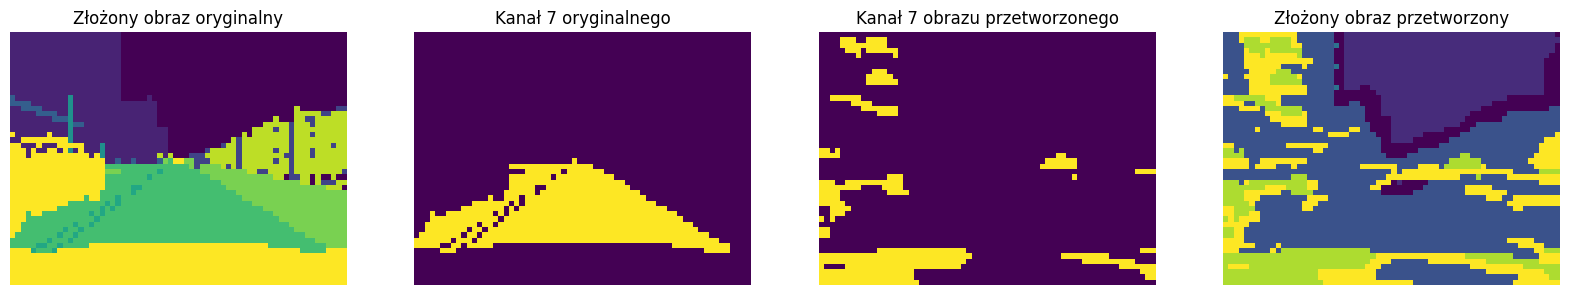

In [158]:
'''     Opis etykiet (kanałów obrazu):
0   TŁO
1   BUDYNKI
2   OGRODZENIA / PŁOTY / BARIERKI
3   ELEMENTY BUDYNKÓW
4   PIESI
5   SŁUPY / LATARNIE
6   ZNAKI POZIOME
7   JEZDNIA
8   CHODNIK
9   ROŚLINNOŚĆ
10  POJAZDY
11  SYGNALIZACJA ŚWIETLNA
'''

# idex obrazu w zbiorze
image_index = 0
# idex kanału do wyświetlenia
image_channel = 7
display_images(segmented_images, convoled, image_index=image_index, channel_index=image_channel)

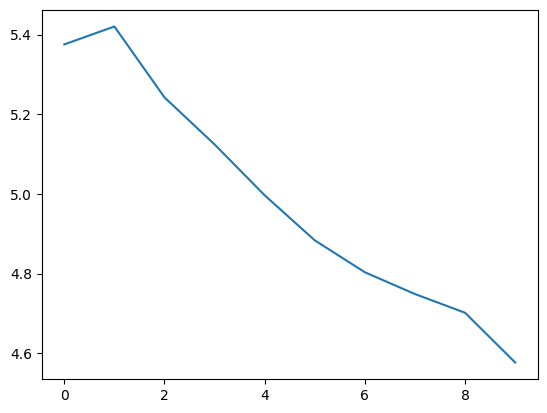

In [112]:
plt.plot(loss)

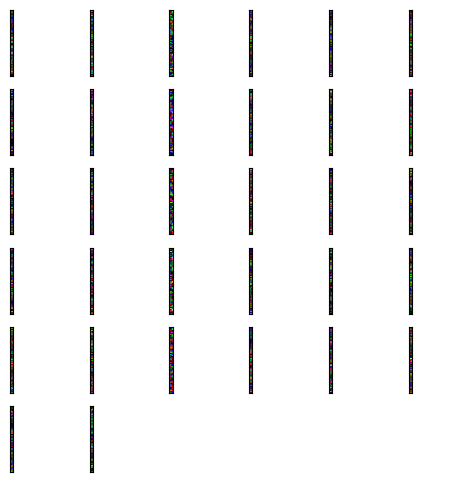

In [66]:
visualize_weights(autoenkoder.relumid.forward(autoenkoder.convmid.kernels))